In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import (
    LeastSquares,
    TotalLeastSquares,
    RecursiveLeastSquares,
    NonNegativeLeastSquares,
    LeastMeanSquares,
    AffineLeastMeanSquares,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.save_load import save_model, load_model

warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Times New Roman"

In [33]:
# read data from pickle 
building_results = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/building_results.pkl')
office_elec = pd.read_pickle('C:/Users/yangzhec/OneDrive - KTH/Projects/HYSTORE/PCM_flexibility_mdp/data/office_load.pkl')

In [34]:
# calculate the average temp by assuming single thermal zone
building_results['avetemp'] = (building_results['TAIR_Office1             '] + building_results['TAIR_Office2             '] +
                             building_results['TAIR_Office1             '] + building_results['TAIR_Office4             '] +
                             building_results['TAIR_Office5             '] + building_results['TAIR_Office6             '] +
                             building_results['TAIR_Office7             '] + building_results['TAIR_Office8             ']) / 8

In [35]:
# seperate cooling season data (Jun, Jul, and Aug) 
office_elec_cs = office_elec[(office_elec.index.month==5) | (office_elec.index.month==6) | (office_elec.index.month==7) | (office_elec.index.month==8)]
building_results_cs = building_results[(building_results.index.month==5) | (building_results.index.month==6) | (building_results.index.month==7) | (building_results.index.month==8)]

In [36]:
total_df = pd.concat([building_results_cs, office_elec_cs], axis=1)
#total_df['Electricity Demand-TOT Cooling'].shift(-1)
total_df.dropna(inplace=True, axis=0)

display(total_df)

,Simulation_month,Day_of_the_month,Hour_of_the_day,TIME,TAIR_Office1,TOP_Office1,QINF_Office1,RELHUM_Office1,QSOLTR_Office1,QTABSI_Office1,...,avetemp,Hour_of_the_day,TIME,TOT-Total Electricity Demand,Electricity Demand-TOT Heating,Electricity Demand-TOT Cooling,Electricity Demand-TOT Electric Equipment,Electricity Demand-TOT Lighting,Thermal energy need for space cooling [kWh],Thermal power requirement for space cooling [kW]
2021-05-01 00:00:00,4,30,24,2880,16.234475,16.20887,-171.834636,80.240317,0,-0.0,...,15.995386,24,2880,0,0,0,0,0,0,0
2021-05-01 00:15:00,5,1,1,2880.25,15.91465,15.992448,-148.694681,82.236283,0,0.0,...,15.65284,1,2880.25,0,0,0,0,0,0,0
2021-05-01 00:30:00,5,1,1,2880.5,15.946273,16.014588,-148.575812,82.631341,0,0.0,...,15.661836,1,2880.5,0,0,0,0,0,0,0
2021-05-01 00:45:00,5,1,1,2880.75,15.94911,16.017044,-145.737749,83.446408,0,-0.0,...,15.663591,1,2880.75,0,0,0,0,0,0,0
2021-05-01 01:00:00,5,1,1,2881,15.954859,16.021528,-142.962565,84.467683,0,0.0,...,15.668199,1,2881,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 22:45:00,8,31,23,5830.75,29.798814,29.942441,-327.382466,66.110812,0,-0.0,...,29.342306,23,5830.75,0,0,0,0,0,0,0
2021-08-31 23:00:00,8,31,23,5831,29.770897,29.920997,-340.079919,65.767903,0,0.0,...,29.316742,23,5831,0,0,0,0,0,0,0
2021-08-31 23:15:00,8,31,24,5831.25,29.743323,29.899913,-356.0842,65.561749,0,0.0,...,29.29232,24,5831.25,0,0,0,0,0,0,0
2021-08-31 23:30:00,8,31,24,5831.5,29.710127,29.87518,-377.115999,65.634747,0,0.0,...,29.265367,24,5831.5,0,0,0,0,0,0,0


In [37]:
# split training and validation sets (Jun Jul as training, Aug as validation)
train_df = total_df[total_df.index.month!=8]
test_df = total_df[total_df.index.month==8]

X_train = train_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_train = train_df['avetemp'].values.reshape(-1,1).astype(float)

X_test = test_df[['Electricity Demand-TOT Cooling', 'T                        ']].values.astype(float)
y_test = test_df['avetemp'].values.reshape(-1,1).astype(float)

Polynomial with FROLS estimator

In [44]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares()

frols_model = FROLS(
    order_selection=True,
    n_terms=10,
    ylag=2,
    xlag=[[1, 2], [1, 2]],
    info_criteria="aic",
    estimator=estimator,
    basis_function=basis_function,
)

frols_model.fit(X=X_train, y=y_train)

In [45]:
yhat = frols_model.predict(X=X_test, y=y_test, steps_ahead=1)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

0.18223861821678544


In [46]:
r = pd.DataFrame(
    results(
        frols_model.final_model,
        frols_model.theta,
        frols_model.err,
        frols_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

      Regressors   Parameters             ERR
0         y(k-1)   1.4072E+00  9.99920656E-01
1         y(k-2)  -4.2461E-01  1.49227836E-05
2        x2(k-1)   1.5524E+00  1.15632661E-06
3  x2(k-2)y(k-1)   1.5755E-03  8.80612151E-07
4  x2(k-2)y(k-2)   5.6091E-02  5.56023809E-07
5        x2(k-2)  -1.5262E+00  2.91227332E-07
6  x2(k-1)y(k-2)  -5.7973E-02  7.65675263E-07
7      x1(k-1)^2   2.4724E-02  3.09348772E-07
8  x1(k-1)y(k-1)  -1.1731E-01  7.95267384E-07
9  x1(k-1)y(k-2)   1.1421E-01  4.43073777E-07


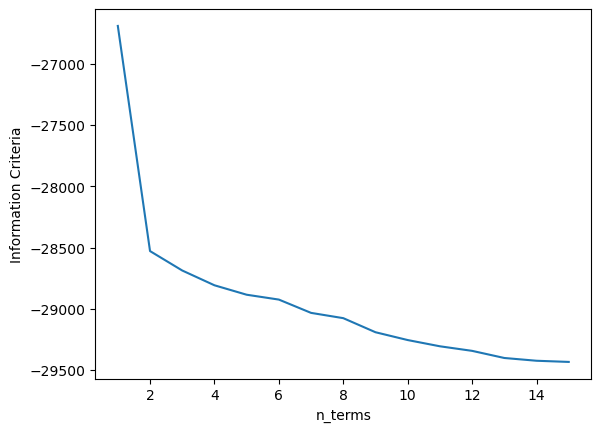

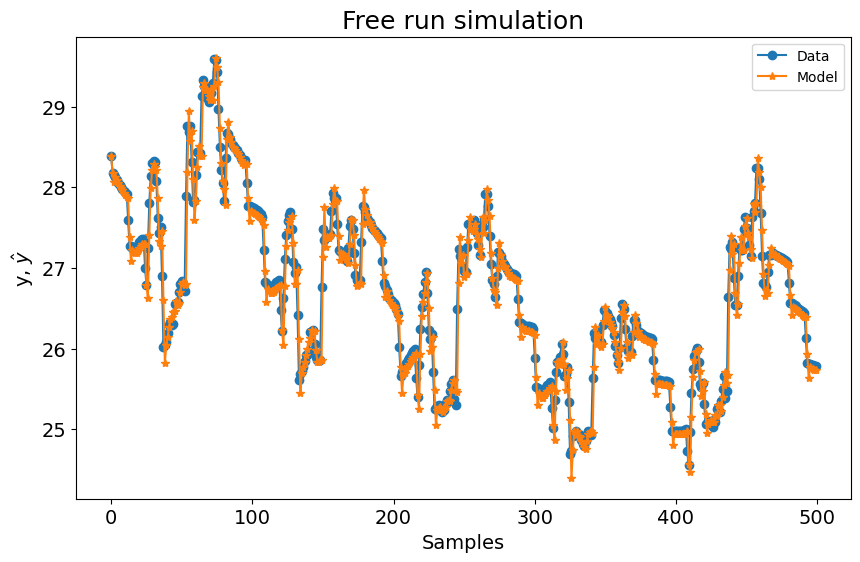

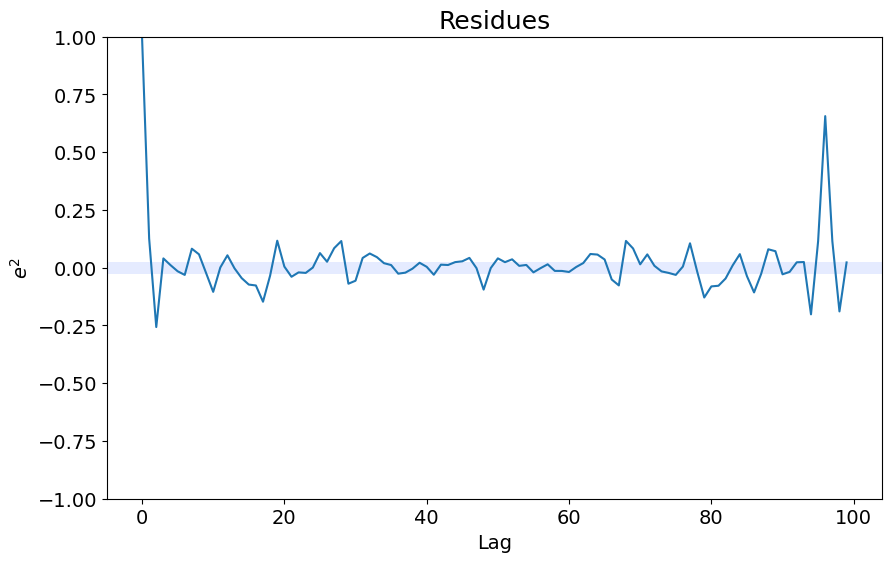

In [47]:
xaxis = np.arange(1, frols_model.n_info_values + 1)
plt.plot(xaxis, frols_model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")
plot_results(y=y_test, yhat=yhat, n=500)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

In [42]:
save_model(model=frols_model, file_name="indoor_frols.syspy")


 Original model 
       Regressors   Parameters             ERR
0         y(k-1)   2.1257E+00  9.99920652E-01
1         y(k-2)  -1.3655E+00  1.49280551E-05
2         y(k-3)   2.2173E-01  3.75693258E-06
3        x2(k-1)   1.9534E+00  1.19910852E-06
4        x2(k-2)  -3.7413E+00  1.28143128E-06
5        x2(k-3)   1.8122E+00  1.94418491E-06
6       y(k-1)^2  -2.5319E-02  3.46042561E-07
7   y(k-2)y(k-1)   2.5137E-02  4.31588018E-07
8      x1(k-1)^2   2.1911E-02  1.32918145E-07
9  x1(k-1)y(k-1)  -2.9284E-03  6.74818684E-07

 Model Loaded from file 
       Regressors   Parameters             ERR
0         y(k-1)   2.1257E+00  9.99920652E-01
1         y(k-2)  -1.3655E+00  1.49280551E-05
2         y(k-3)   2.2173E-01  3.75693258E-06
3        x2(k-1)   1.9534E+00  1.19910852E-06
4        x2(k-2)  -3.7413E+00  1.28143128E-06
5        x2(k-3)   1.8122E+00  1.94418491E-06
6       y(k-1)^2  -2.5319E-02  3.46042561E-07
7   y(k-2)y(k-1)   2.5137E-02  4.31588018E-07
8      x1(k-1)^2   2.1911E-02  1.3

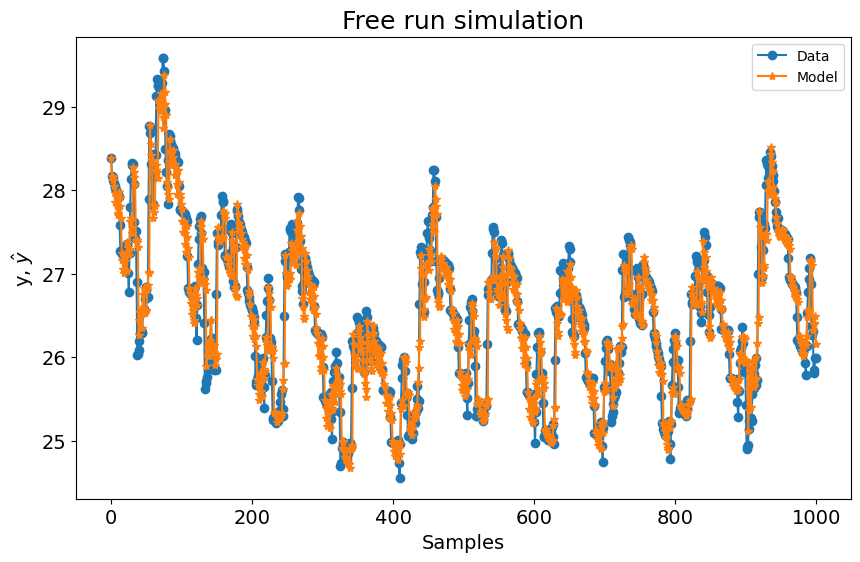

In [43]:
loaded_model = load_model(file_name="indoor_frols.syspy")
# Predicting output with loaded_model
yhat_loaded = loaded_model.predict(X=X_test, y=y_test, steps_ahead=4)

r_loaded = pd.DataFrame(
    results(
        loaded_model.final_model,
        loaded_model.theta,
        loaded_model.err,
        loaded_model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)

# Printing both: original model and model loaded from file
print("\n Original model \n", r)
print("\n Model Loaded from file \n", r_loaded)

# Checking predictions from both: original model and model loaded from file
if (yhat == yhat_loaded).all():
    print("\n Predictions are the same!")

# Ploting results
plot_results(y=y_test, yhat=yhat_loaded, n=1000)